# Associations between microbial presence/absence and patient info

In [9]:
setwd("/mnt/c/Users/Cedric/Desktop/git_repos/blood_microbiome")
require(tidyverse)
require(ggplot2)
require(data.table)
require(foreach)
require(doParallel)
require(ggrepel)
require(Maaslin2)
registerDoParallel(cores = 10)


### Load  data

In [80]:
X <- fread("results/decontamination/read_matrix_n125.global_decontaminated.zeroed.csv")
X <- fread("results/decontamination/RA_matrix_n125.global_decontaminated.zeroed.csv")
X <- fread("results/decontamination/")

meta <- fread("data/20210125_v3_release/20210203_all_traits_v3.txt")
meta2 <- fread("data/SG10K_Health_metadata.n10714.16March2021.parsed.csv")

n <- gsub("[^0-9A-Za-z///' ]", " ", colnames(meta))
n <- tolower(n)
n <- gsub(" ", "_", n)
colnames(meta) <- n

fwrite(meta, "data/20210125_v3_release/20210203_all_traits_v3.parsed.csv")
X_meta <- X %>%
    left_join(meta, "npm_research_id") %>%
    left_join(meta2, "npm_research_id") %>%
    as_tibble()

head(X_meta)

npm_research_id,Cutibacterium acnes,Mitsuaria sp. 7,Microbacterium hominis,Microbacterium sp. PM5,Bacillus cereus,Moraxella osloensis,Burkholderia contaminans,Human mastadenovirus C,Microbacterium sp. Y-01,⋯,supplied_and_computed_gender_match,sop_agreement_for_coverage__14/_28_for_15x/30x,sample_life_cycle,current,source_cohort,original_supplier_id,duplicate_info.y,duplicate.y,duplicate_pair.y,removal_requested_by_supplier
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
WHB8678,0,0,0,1,0,0,0,0,0,⋯,Y,Y,MEC VCF,Y,MEC,17003-2474,Unknown,PASS,Unknown,Unknown
WHB9470,0,1,0,0,0,0,0,0,0,⋯,Y,Y,HELIOS VCF,Y,HELIOS,02753,Unknown,PASS,Unknown,Unknown
WHB4637,0,0,0,0,0,0,0,0,0,⋯,Y,Y,GUSTO_Kids VCF,Y,GUSTO_Kids,010-20811,Unknown,PASS,Unknown,Unknown
WHB6790,1,0,0,0,0,0,0,0,0,⋯,Y,Y,MEC VCF,Y,MEC,17003-0586,Unknown,PASS,Unknown,Unknown
WHH1857,0,0,0,0,0,0,0,0,0,⋯,Y,Y,SEED VCF,Y,SEED_mini,MS16704,Unknown,PASS,Unknown,Unknown
WHB5810,0,0,0,0,0,0,0,0,0,⋯,Y,Y,HELIOS VCF,Y,HELIOS,01635,Unknown,PASS,Unknown,Unknown


In [81]:
# Get variable lists
taxon_list <- colSums(X[, 2:ncol(X)]) >= 50
taxon_list <- names(taxon_list[taxon_list])
length(taxon_list)

categorical_list <- c("fasting", "genetic_sex", "genetic_ancestry", 
                      "diab_med", "htn_med", "lipid_med", "t2d")
cont_list <- c("age", "bmi", 
               "height_cm", "weight_kg", "waistc_cm", "hipc_cm", 
               "tc_mmol_l", "ldl_direct_mmol_l", "hdl_mmol_l", "tg_mmol_l",
               "glu_fast_mmol_l", "ins_fast_uiu_ml", "glu_rand_mmol_l",
               "ldl_cal_mmol_l",              
               "sbp", "dbp")

n_comparisons <- length(taxon_list) * length(categorical_list) + length(taxon_list) * length(cont_list)
n_comparisons

[1] 14

[1] 322

## Phenotype association tests

In [49]:
category <- categorical_list[1]
taxon <- "Cutibacterium acnes"
X_meta_filt <- X_meta %>% 
    filter(!is.na(get(category)))
var_vec <- deframe(X_meta_filt[, category])
species_vec <- deframe(X_meta_filt[, taxon])
cohort_vec <- X_meta_filt$site_supplying_sample
ext_vec <- X_meta_filt$extraction_kit

logreg <- glm(species_vec ~ cohort_vec + ext_vec + var_vec, family = "binomial")
log_reg
summary(logreg)

In [82]:
X_meta_filt <- X_meta %>%
    column_to_rownames("npm_research_id")

species_dat <- X_meta_filt[, 1:125]
species_dat[1:5, 1:5]
meta_dat <- X_meta_filt[, 126:ncol(X_meta_filt)]
meta_dat[1:5, 1:5]

,Cutibacterium acnes,Mitsuaria sp. 7,Microbacterium hominis,Microbacterium sp. PM5,Bacillus cereus
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
WHB8678,0,0,0,1,0
WHB9470,0,1,0,0,0
WHB4637,0,0,0,0,0
WHB6790,1,0,0,0,0
WHH1857,0,0,0,0,0


,original_wgs_ids,supplier_id.x,timepoint,age,cc_status
,<chr>,<chr>,<int>,<dbl>,<int>
WHB8678,WHB8678,17003-2474,0,28.0,0
WHB9470,WHB9470,2753,0,57.4,0
WHB4637,WHB4637,010-20811,0,NA,0
WHB6790,WHB6790,17003-0586,0,47.0,0
WHH1857,WHH1857,MS16704,0,56.0,0


In [86]:
fit_data <- Maaslin2(
    input_data = species_dat, 
    input_metadata = meta_dat, 
    normalization = "CLR",
    analysis_method = "CPLM",
    output = "results/phenotype_associations/demo_output", 
    fixed_effects = cont_list,
    random_effects = c("site_supplying_sample", "extraction_kit"),
    reference = c("genetic_ancestry,C"),
    min_prevalence = 0.001)

[1] "Warning: Deleting existing log file: results/phenotype_associations/demo_output/maaslin2.log"
2022-03-21 15:33:12 INFO::Writing function arguments to log file
2022-03-21 15:33:12 INFO::Verifying options selected are valid
2022-03-21 15:33:12 INFO::Determining format of input files
2022-03-21 15:33:12 INFO::Input format is data samples as rows and metadata samples as rows
2022-03-21 15:33:12 INFO::Formula for random effects: expr ~ (1 | site_supplying_sample) + (1 | extraction_kit)
2022-03-21 15:33:12 INFO::Formula for fixed effects: expr ~  age + bmi + height_cm + weight_kg + waistc_cm + hipc_cm + tc_mmol_l + ldl_direct_mmol_l + hdl_mmol_l + tg_mmol_l + glu_fast_mmol_l + ins_fast_uiu_ml + glu_rand_mmol_l + ldl_cal_mmol_l + sbp + dbp
2022-03-21 15:33:12 INFO::Filter data based on min abundance and min prevalence
2022-03-21 15:33:12 INFO::Total samples in data: 2161
2022-03-21 15:33:12 INFO::Min samples required with min abundance for a feature not to be filtered: 2.161000
2022-03-2

Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs produced”
Warning message in FUN(newX[, i], ...):
“NaNs pr

2022-03-21 15:33:13 INFO::Running selected analysis method: CPLM
2022-03-21 15:33:13 INFO::Fitting model to feature number 1, Cutibacterium.acnes
Error : Invalid grouping factor specification, site_supplying_sample
2022-03-21 15:33:13 WARNING::Fitting problem for feature 1 returning NA
2022-03-21 15:33:13 INFO::Fitting model to feature number 2, Mitsuaria.sp..7
Error : Invalid grouping factor specification, site_supplying_sample
2022-03-21 15:33:13 WARNING::Fitting problem for feature 2 returning NA
2022-03-21 15:33:13 INFO::Fitting model to feature number 3, Microbacterium.hominis
Error : Invalid grouping factor specification, site_supplying_sample
2022-03-21 15:33:13 WARNING::Fitting problem for feature 3 returning NA
2022-03-21 15:33:13 INFO::Fitting model to feature number 4, Microbacterium.sp..PM5
Error : Invalid grouping factor specification, site_supplying_sample
2022-03-21 15:33:13 WARNING::Fitting problem for feature 4 returning NA
2022-03-21 15:33:13 INFO::Fitting model to fe

In [75]:
fit_data <- Maaslin2(
    input_data = species_dat, 
    input_metadata = meta_dat, 
    output = "results/phenotype_associations/demo_output", 
    fixed_effects = c(categorical_list),
    random_effects = c("site_supplying_sample", "extraction_kit"),
    reference = c("genetic_ancestry,C"),
    min_prevalence = 0.005)

[1] "Warning: Deleting existing log file: results/phenotype_associations/demo_output/maaslin2.log"
2022-03-21 15:28:25 INFO::Writing function arguments to log file
2022-03-21 15:28:25 INFO::Verifying options selected are valid
2022-03-21 15:28:25 INFO::Determining format of input files
2022-03-21 15:28:25 INFO::Input format is data samples as rows and metadata samples as rows
2022-03-21 15:28:25 INFO::Formula for random effects: expr ~ (1 | site_supplying_sample) + (1 | extraction_kit)
2022-03-21 15:28:25 INFO::Formula for fixed effects: expr ~  fasting + genetic_sex + genetic_ancestry + diab_med + htn_med + lipid_med + t2d + age + bmi + height_cm + weight_kg + waistc_cm + hipc_cm + tc_mmol_l + ldl_direct_mmol_l + hdl_mmol_l + tg_mmol_l + glu_fast_mmol_l + ins_fast_uiu_ml + glu_rand_mmol_l + ldl_cal_mmol_l + sbp + dbp
2022-03-21 15:28:25 INFO::Filter data based on min abundance and min prevalence
2022-03-21 15:28:25 INFO::Total samples in data: 8617
2022-03-21 15:28:25 INFO::Min sample

In [7]:
cat_morsels <- foreach (category = categorical_list) %dopar% {
    X_meta_filt <- X_meta %>% filter(!is.na(get(category)))
    var_vec <- deframe(X_meta_filt[, category])
    
    foreach (taxon = taxon_list) %do% {
        species_vec <- deframe(X_meta_filt[, taxon])
        
        if(sum(species_vec) > 0 & length(unique(var_vec)) >= 2) {
#             test <- chisq.test(var_vec, species_vec, simulate.p.value = T, B = 1000)
            test <- chisq.test(var_vec, species_vec)
            return(tibble(taxa = taxon, variable = category, chisq = test$statistic, p = test$p.value))
        } else {
            return(tibble(taxa = taxon, variable = category, chisq = NA, p = NA))
        }
    }
}

cat_res <- bind_rows(cat_morsels)

In [8]:
cont_morsels <- foreach (cont = cont_list) %dopar% {
    X_meta_filt <- X_meta %>% filter(!is.na(get(cont)))
    var_vec <- deframe(X_meta_filt[, cont])
    
    foreach (taxon = taxon_list) %do% {
        species_vec <- deframe(X_meta_filt[, taxon])
        
        if(sum(species_vec) > 0) {
            test <- wilcox.test(var_vec ~ species_vec, correct = F) 
            return(tibble(taxa = taxon, variable = cont, 
                          U = test$statistic, 
                          p = test$p.value))
        } else {
            return(tibble(taxa = taxon, variable = cont, 
                                      U = NA, 
                                      p = NA))
        }
    }
}

cont_res <- bind_rows(cont_morsels)

Saving 12 x 6.67 in image



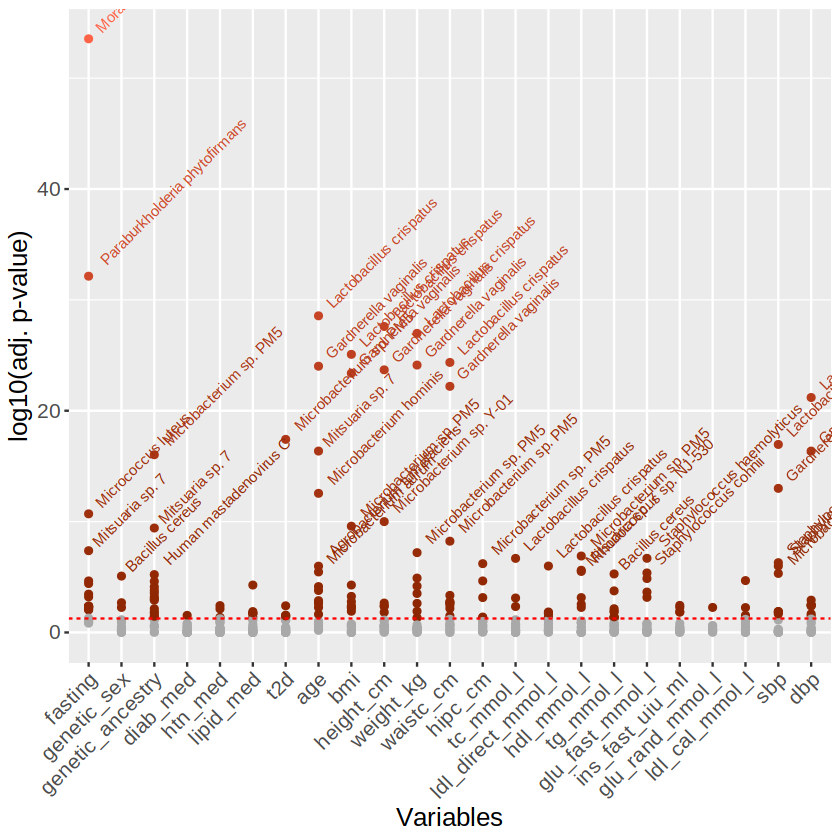

In [22]:
res <- cat_res %>%
    bind_rows(cont_res)

n_not_tested <- res %>%
    filter(is.na(p)) %>%
    nrow()

n_comparisons_final <- n_comparisons - n_not_tested
a <- 0.05

res_filt <- res %>%
    filter(!is.na(p)) %>%
    mutate(p.adj = p.adjust(p, "BH", n = n_comparisons_final)) %>%
    mutate(log_p_adj = -log(p.adj, base = 10),
           annot = ifelse(log_p_adj > 5, taxa, ""),
           variable = factor(variable, levels = c(categorical_list, cont_list)),
           color_value = ifelse(p.adj > a, NA, log_p_adj))

assoc_plt <- res_filt %>%
    ggplot(aes(x = variable, y = log_p_adj, color = color_value)) +
    geom_point() +
    geom_hline(yintercept = -log(a, base = 10), 
               lty = "dashed",
               color = "red") +
    scale_color_gradient(low = "orangered4", high = "tomato1", na.value = "darkgray") + 
    theme(axis.text.x = element_text(angle = 45, hjust = 1),
          text = element_text(size = 15),
          legend.position = "none") +
    geom_text(aes(label = annot), angle = 45, hjust = -0.1, size = 3) +
    labs(x = "Variables", y = "log10(adj. p-value)")
assoc_plt

ggsave("results/phenotype_associations/manhattan_plot.png", plot = assoc_plt, dpi = 600, width = 12)

Saving 6.67 x 6.67 in image



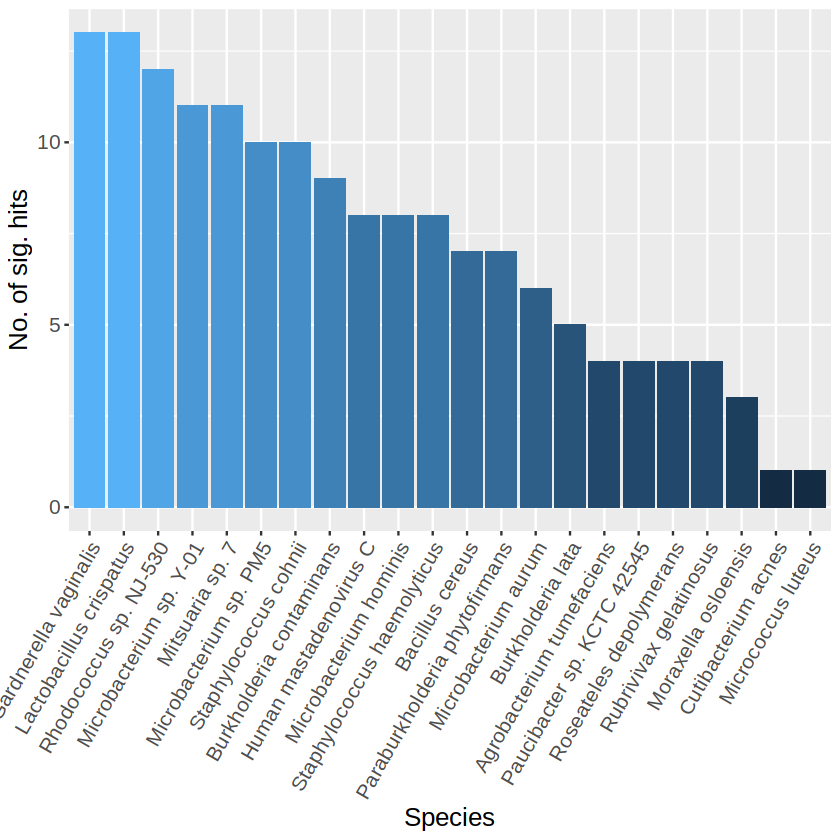

In [24]:
taxa_counts <- res_filt %>%
    mutate(is_sig = ifelse(p.adj <= a, T, F)) %>%
    filter(is_sig) %>%
    group_by(taxa) %>%
    summarise(n = n()) %>%
    arrange(desc(n))

hit_plt <- taxa_counts %>%
    mutate(taxa = factor(taxa, unique(taxa_counts$taxa))) %>%
    ggplot(aes(x = taxa, y = n, fill = n)) +
    geom_bar(stat = "identity") +
    theme(legend.position = "none", 
          axis.text.x = element_text(angle = 60, hjust = 1),
          text = element_text(size = 15)) +
    labs(x = "Species", y = "No. of sig. hits")

hit_plt
ggsave("results/phenotype_associations/assoc_hit_count_barchart.png", dpi = 600)

### Probing L. crispatus

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 86 rows containing non-finite values (stat_bin).”
Saving 6.67 x 6.67 in image

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Warning message:
“Removed 86 rows containing non-finite values (stat_bin).”


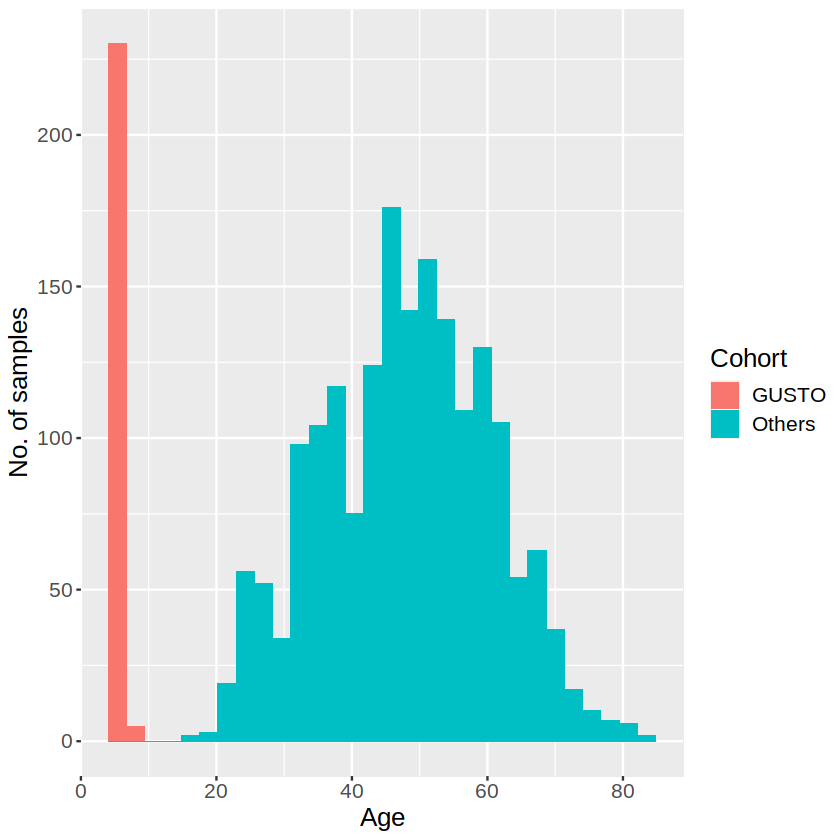

In [25]:
age_plt <- X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    mutate(is_gusto = ifelse(site_supplying_sample == "GUSTO", "GUSTO", "Others")) %>%
    ggplot(aes(x = age, fill = is_gusto)) +
        geom_histogram() +
        labs(x = "Age", y = "No. of samples", fill = "Cohort") +
        theme(text = element_text(size = 15))
age_plt 
ggsave("results/phenotype_associations/age_distribution_barchart.png", dpi = 600)

In [26]:
X_meta %>% 
    left_join(meta2, "npm_research_id") %>%
    filter(site_supplying_sample == "GUSTO") %>%
    summarise(med = median(age, na.rm = T))

med
<dbl>
6.1


In [37]:
X_meta %>% 
    left_join(meta2, "npm_research_id") %>%
    filter(site_supplying_sample == "SERI") %>%
    arrange(age) %>%
    select(age)

age
<dbl>
40.00000
40.00000
40.00000
41.00000
41.00000
41.00000
41.00000
41.00000
42.00000


`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

Saving 6.67 x 6.67 in image

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



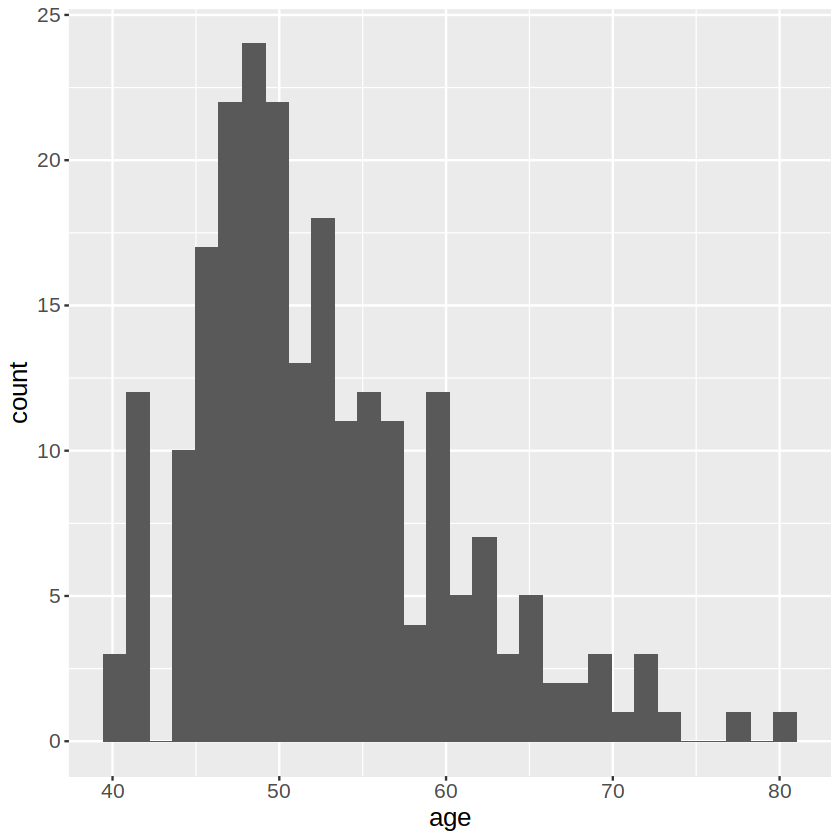

In [34]:
gusto_age_plt <- X_meta %>% 
    left_join(meta2, "npm_research_id") %>%
    filter(site_supplying_sample == "SERI") %>%
    ggplot(aes(x = age)) +
        geom_histogram() +
#         xlim(5.5, 8) +
        theme(text = element_text(size = 15))

gusto_age_plt
ggsave("results/phenotype_associations/age_distribution_GUSTO_barchart.png", dpi = 600)

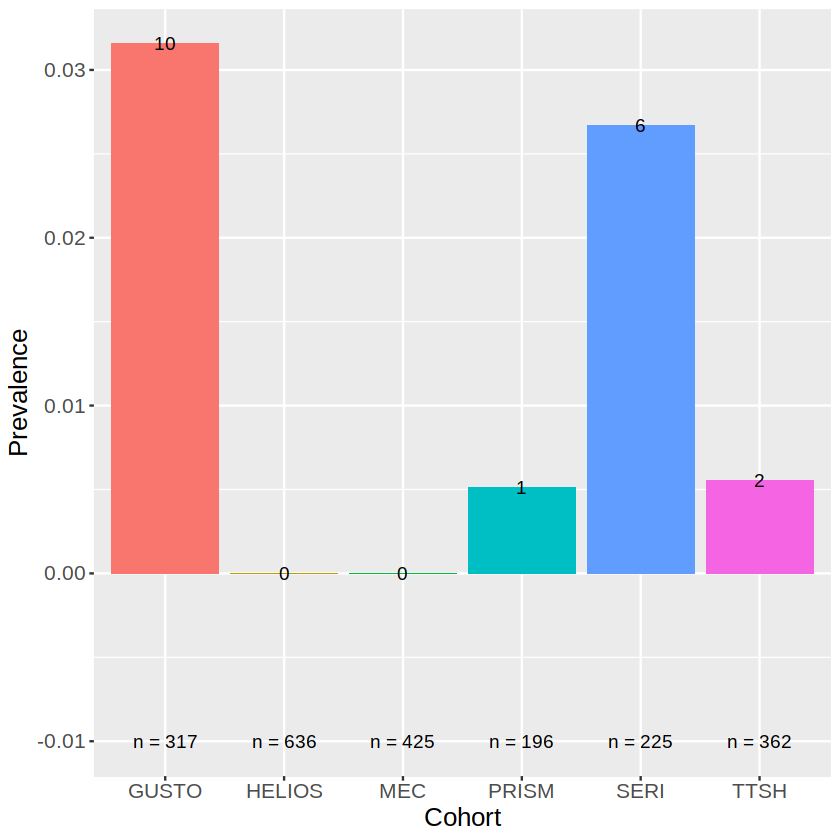

In [32]:
taxon <- "Lactobacillus crispatus"
taxon <- "Acinetobacter baumannii"
prev_plt <- X_meta %>%
    left_join(meta2, "npm_research_id") %>%
    group_by(site_supplying_sample) %>%
    summarise(prevalence = sum(get(taxon)) / n(), n_pos = sum(get(taxon)), n_samples = n()) %>%
    ggplot(aes(x = site_supplying_sample, y = prevalence, fill = site_supplying_sample)) +
        geom_bar(stat = "identity") +
        geom_text(aes(y = -0.01, label = str_glue("n = {n_samples}"))) +
        geom_text(aes(label = n_pos)) +
        theme(legend.position = "none", 
              text = element_text(size = 15)) +
        labs(x = "Cohort", y = "Prevalence")

prev_plt

# ggsave("results/phenotype_associations/L_crisptus_prevalence_barchart.png", dpi = 600)

In [ ]:
X_meta %>% 
    left_join(meta2, "npm_research_id") %>%
    group_by(fasting, site_supplying_sample) %>%
    summarise(n = n()) %>%
    ggplot(aes(x = fasting, y = n, fill = site_supplying_sample)) +
    geom_bar(stat = "identity", position = "stack")

In [ ]:
taxon <- "Moraxella osloensis"
X_meta %>%
    group_by_at(c("fasting", taxon)) %>%
    summarise(n = n()) %>%
    filter(!is.na(fasting)) %>%
    ggplot(aes(x = get(taxon), y = n, fill = fasting)) +
    geom_bar(stat = "identity", position = "stack")